In [452]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import rcParams
import numpy as np
from sklearn import preprocessing

import json
import glob
from natsort import natsorted
import pandas as pd

# import matplotlib.font_manager
# print([f.name for f in matplotlib.font_manager.fontManager.ttflist])


### データフレームに落とし込むための辞書を初期化

In [453]:
flnum = 9
dict = {'building':[],'floor':[],'pool_size':[],'batch':[], 'elv_size':[],'robonum':[],'roboalloc':[], 'comp_time':[], 'dloc_time':[]} #robo_f1_at, robo_f1_td, robo_f2_at,...., e_at, e_td
for i in range(1, flnum+1):
    dict['robo_f{}_mt'.format(str(i).zfill(2))] = []    # move time
    dict['robo_f{}_at'.format(str(i).zfill(2))] = []    # action time
    dict['robo_f{}_st'.format(str(i).zfill(2))] = []    # standby time
    dict['robo_f{}_td'.format(str(i).zfill(2))] = []    # travel distance
    
dict['robo_mean_mt'] = []    # mean move time
dict['robo_mean_at'] = []    # mean action time
dict['robo_mean_st'] = []    # mean standby time
dict['robo_mean_td'] = []    # mean travel distance

dict['elv_mt'] = []
dict['elv_st'] = []
dict['elv_td'] = []
print(dict.keys())


dict_keys(['building', 'floor', 'pool_size', 'batch', 'elv_size', 'robonum', 'roboalloc', 'comp_time', 'dloc_time', 'robo_f01_mt', 'robo_f01_at', 'robo_f01_st', 'robo_f01_td', 'robo_f02_mt', 'robo_f02_at', 'robo_f02_st', 'robo_f02_td', 'robo_f03_mt', 'robo_f03_at', 'robo_f03_st', 'robo_f03_td', 'robo_f04_mt', 'robo_f04_at', 'robo_f04_st', 'robo_f04_td', 'robo_f05_mt', 'robo_f05_at', 'robo_f05_st', 'robo_f05_td', 'robo_f06_mt', 'robo_f06_at', 'robo_f06_st', 'robo_f06_td', 'robo_f07_mt', 'robo_f07_at', 'robo_f07_st', 'robo_f07_td', 'robo_f08_mt', 'robo_f08_at', 'robo_f08_st', 'robo_f08_td', 'robo_f09_mt', 'robo_f09_at', 'robo_f09_st', 'robo_f09_td', 'robo_mean_mt', 'robo_mean_at', 'robo_mean_st', 'robo_mean_td', 'elv_mt', 'elv_st', 'elv_td'])


## File load

In [454]:
n =0
for bldg in ['small_warehouse_e10', 'large_warehouse',]:
    for fl in [3, 6, 9]:
        for p in range(1,11):
            l_path = '../record/{}/floor0{}/robonum0*/P/pool0{}/*.json'.format(bldg, fl, str(p**2).zfill(3))
            # print(glob.glob(l_path))
            l_files = natsorted(glob.glob(l_path))
            n+=len(l_files)
            # print(n)
            # print(file.split('/')[-1] lambda x: file in l_files)

            for l_file in l_files:
                # print(l_file.split('/')[2:])
                content = []
                with open(l_file) as f:
                    content = json.load(f)
                    dict['building'].append(content['config']['building_type'])
                    dict['floor'].append(fl)
                    pla = p**2
                    # dict['pool_size'].append(p**2*1.5)
                    dict['pool_size'].append(pla)
                    if 'batch'in content['input'].keys():
                        if content['input']['batch']:
                            if content['input']['batch'] > p**2*1.5*0.8:
                                dict['batch'].append((p**2*1.5*0.8//0.5+1)*0.5)
                            else:
                                dict['batch'].append(content['input']['batch'])
                        else:dict['batch'].append(((p**2)*1.5*0.8//0.5+1)*0.5)
                    else:
                        # if p== 8.0:
                        #     print(((p**2)*1.5*0.8//0.5+1)*0.5)
                        dict['batch'].append(((p**2)*1.5*0.8//0.5+1)*0.5)
                    elvsize = content['config']['floor1']['elevator']
                    dict['elv_size'].append(abs((elvsize[0]-elvsize[3])*(elvsize[1]-elvsize[4])))
                    dict['robonum'].append(sum(content['input']['robot_allocation']))
                    dict['roboalloc'].append(str(content['input']['robot_allocation']))
                    dict['comp_time'].append(float(content['output']['complete_time']))
                    if 'deadloc_time' in content['output'].keys():
                        dict['dloc_time'].append(float(content['output']['deadloc_time']))
                    else:
                        dict['dloc_time'].append(0)
                    
                    fl_robo = {}
                    for i in range(1,flnum+1):
                        fl_robo[i] = {}
                        fl_robo[i]['mt'] = []
                        fl_robo[i]['at'] = []
                        fl_robo[i]['st'] = []
                        fl_robo[i]['td'] = []
                    mean_mt = []
                    mean_at = []
                    mean_st = []
                    mean_td = []
                    for robo, info in content['info']['robot'].items():
                        # print(robo, info)
                        fl_robo[int(info['floor'])]['mt'].append(float(info['move_time']))
                        fl_robo[int(info['floor'])]['at'].append(float(info['action_time']))
                        fl_robo[int(info['floor'])]['st'].append(float(info['standby_time']))
                        fl_robo[int(info['floor'])]['td'].append(float(info['travel_distance']))
                        
                    for j in range(1,flnum+1):
                        if fl_robo[j]['mt']:
                            # print(fl_robo[fl]['mt'])
                            dict['robo_f{}_mt'.format(str(j).zfill(2))].append(round(sum(fl_robo[j]['mt']) / len(fl_robo[j]['mt']),2 ))    # move time
                            dict['robo_f{}_at'.format(str(j).zfill(2))].append(round(sum(fl_robo[j]['at']) / len(fl_robo[j]['at']),2 ))    # action time
                            dict['robo_f{}_st'.format(str(j).zfill(2))].append(round(sum(fl_robo[j]['st']) / len(fl_robo[j]['st']),2 ))    # standby time
                            dict['robo_f{}_td'.format(str(j).zfill(2))].append(round(sum(fl_robo[j]['td']) / len(fl_robo[j]['td']),2 ))   # travel distance
                            mean_mt.append(round(sum(fl_robo[j]['mt']) / len(fl_robo[j]['mt']),2 ))
                            mean_at.append(round(sum(fl_robo[j]['at']) / len(fl_robo[j]['at']),2 ))
                            mean_st.append(round(sum(fl_robo[j]['st']) / len(fl_robo[j]['st']),2 ))
                            mean_td.append(round(sum(fl_robo[j]['td']) / len(fl_robo[j]['td']),2 )) 
                        else:
                            dict['robo_f{}_mt'.format(str(j).zfill(2))].append(None)    # move time
                            dict['robo_f{}_at'.format(str(j).zfill(2))].append(None)    # action time
                            dict['robo_f{}_st'.format(str(j).zfill(2))].append(None)    # standby time
                            dict['robo_f{}_td'.format(str(j).zfill(2))].append(None)  # travel distance
                    dict['robo_mean_mt'].append(sum(mean_mt)/len(mean_mt))        # mean move time
                    dict['robo_mean_at'].append(sum(mean_at)/len(mean_at))        # mean action time
                    dict['robo_mean_st'].append(sum(mean_st)/len(mean_st))        # mean standby time
                    dict['robo_mean_td'].append(sum(mean_td)/len(mean_td))        # mean travel distance
                    
                    for elv, info in content['info']['elevator'].items():
                        dict['elv_mt'].append(float(info['move_time']))
                        dict['elv_st'].append(float(content['output']['complete_time'])-float(info['move_time']))
                        dict['elv_td'].append(float(info['travel_distance']))
                f.close()
# for k, v in dict.items():
#     print(k, len(v))
# print(dict)
print(n)
# pd.set_option('display.max_rows', 20)
# pd.set_option('display.max_columns', 20)
df = pd.DataFrame(dict)
# df
# df[(df.dloc_time==0.0)&(df.floor==9)&(df.building=='small_warehouse')&(df.batch==59.0)]
# print(df.info())
# print(df[df.dloc_time != 0.0].info())



3356


In [455]:
#df[(df.floor==9)&(df.building=='small_warehouse')&(df.robonum==27)&(df.pool_size>70)&(df.pool_size<90)]

In [456]:
(73.5*0.8//0.5+1)*0.5
p=7
print(((p**2)*1.5*0.8//0.5+1)*0.5)
print((p**2)*1.5)

59.0
73.5


# グラフ可視化

## タスク処理時間での比較

### small warehouse

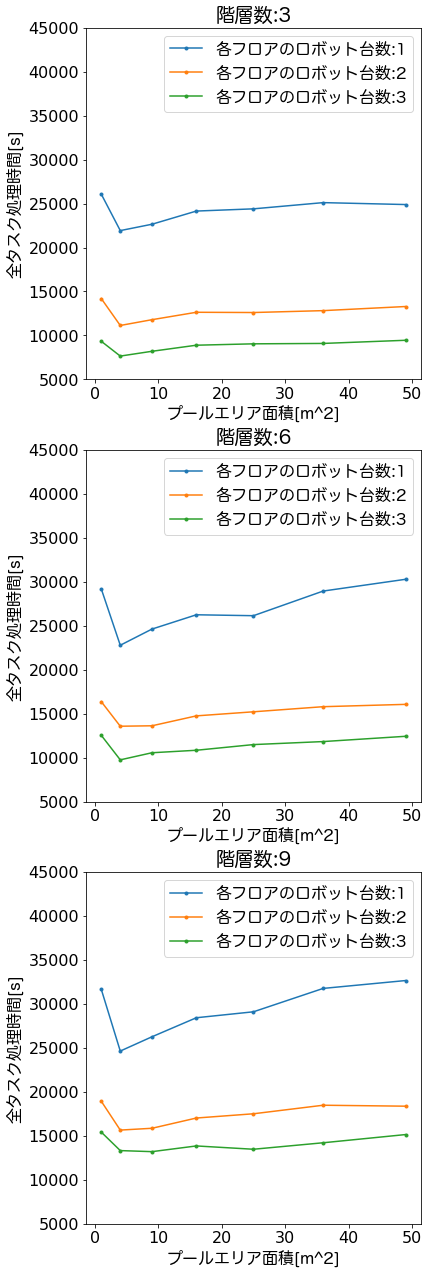

In [543]:
# small_df = df[(df.building=='small_warehouse') & (df.dloc_time==0.0)]
# #tmp = tar_df.groupby('pool_size').mean()
# #tmp.loc[:,'robo_f01_mt':'robo_f03_td'].plot(kind='bar')

# small_df.groupby('pool_size').mean()['comp_time'].plot(kind='bar')
plt.rcParams['font.size']=16
rlist = []
small_df = df[(df.building=='small_warehouse_e10') & (df.dloc_time==0.0) & (df.pool_size < 80)]
small_df
fig = plt.figure(figsize=(6,22))
for fl in range(3,12,3):
    ax = fig.add_subplot(3,1,int(fl//3))
    for rn in range(1,4):
        tmp_df = small_df[(small_df['floor']==fl) & (small_df['roboalloc']==str([rn]*fl))&(small_df['batch']==(small_df['pool_size']*1.5*0.8//0.5+1)*0.5)]
        # print(tmp_df.info())
        # ax = fig.add_subplot(3,3,int(fl/3+(rn-1)*3))
        
        t = tmp_df.groupby(['pool_size']).mean()['comp_time']
        tocsv = t.T
        tocsv.to_csv("./csv/procestime_se10_fl{}_r{}.csv".format(fl,rn))
        #ax.plot([str(tmp) for tmp in t.index],t.values, label='各フロアのロボット台数:{}'.format(rn))
        ax.plot(list(t.index),t.values, label='各フロアのロボット台数:{}'.format(rn),marker=".")
        ax.legend(loc=0,prop={"family":"Hiragino Maru Gothic Pro"})  
        ax.set_title('階層数:{}'.format(fl),fontname="Hiragino Maru Gothic Pro")
        ax.set_xlabel('プールエリア面積[m^2]',fontname="Hiragino Maru Gothic Pro")
        ax.set_ylabel('全タスク処理時間[s]',fontname="Hiragino Maru Gothic Pro")
        ax.set_ylim(5000,45000)

# sd = small_df[(small_df['floor']==fl) & (small_df['roboalloc']==str([rn]*fl))&(small_df['batch']==(small_df['pool_size']*0.8//0.5+1)*0.5)]
# sd

### large warehouse

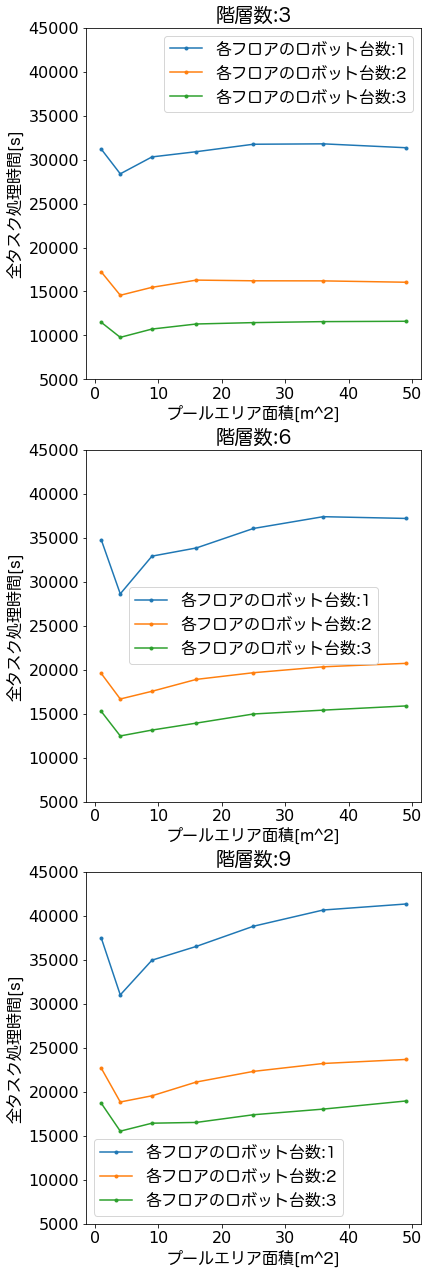

In [545]:
large_df = df[(df.building=='large_warehouse') & (df.dloc_time==0.0)& (df.pool_size < 50)]
fig = plt.figure(figsize=(6,22))
for fl in range(3,12,3):
    ax = fig.add_subplot(3,1,int(fl//3))
    for rn in range(1,4):
        tmp_df = large_df[(large_df['floor']==fl) & (large_df['roboalloc']==str([rn]*fl))&(large_df['batch']==(large_df['pool_size']*1.5*0.8//0.5+1)*0.5)]
        # print(tmp_df.info())
        # ax = fig.add_subplot(3,3,int(fl/3+(rn-1)*3))
        
        t = tmp_df.groupby(['pool_size']).mean()['comp_time']
        # ax.plot([str(tmp) for tmp in t.index],t.values, label='robot:{}'.format(rn))
        ax.plot(list(t.index),t.values, label='各フロアのロボット台数:{}'.format(rn),marker=".")
        ax.legend(loc=0,prop={"family":"Hiragino Maru Gothic Pro"})  
        ax.set_title('階層数:{}'.format(fl),fontname="Hiragino Maru Gothic Pro")
        ax.set_xlabel('プールエリア面積[m^2]',fontname="Hiragino Maru Gothic Pro")
        ax.set_ylabel('全タスク処理時間[s]',fontname="Hiragino Maru Gothic Pro")
        ax.set_ylim(5000,45000)

### ロボット台数ごとのロボット平均移動時間比較

### small warehouse

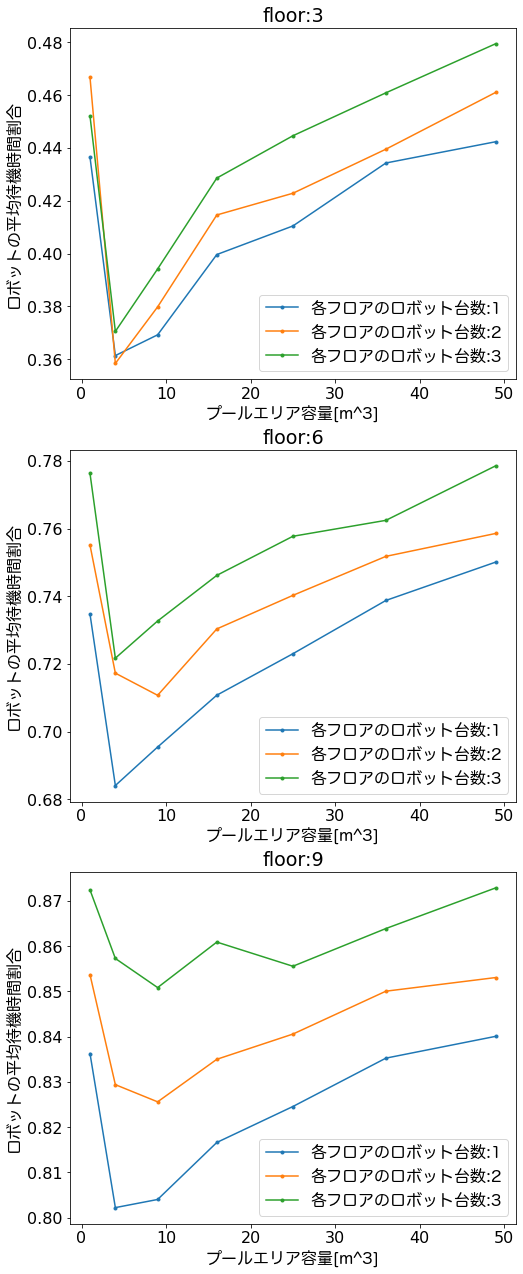

In [548]:

small_df
fig = plt.figure(figsize=(8,22))
for fl in range(3,12,3):
    ax = fig.add_subplot(3,1,int(fl//3))
    for rn in range(1,4):
        tmp_df = small_df[(small_df['floor']==fl) & (small_df['roboalloc']==str([rn]*fl))&(small_df['batch']==(small_df['pool_size']*1.5*0.8//0.5+1)*0.5)]
        # print(tmp_df.info())
        # ax = fig.add_subplot(3,3,int(fl/3+(rn-1)*3))
        
        t = tmp_df.groupby(['pool_size']).mean()['robo_mean_st'].div(tmp_df.groupby('pool_size').mean()['comp_time'])
        #ax.scatter([str(tmp) for tmp in t.index],t.values, label='robot:{}'.format(rn))
        # ax.bar(list(t.index),t.values, label='各フロアのロボット台数:{}'.format(rn),width = 0.8/rn, pos=list(t.index) - 0.8 *( 1- (2*i+1)/rn )/2)
        ax.plot(list(t.index),t.values, label='各フロアのロボット台数:{}'.format(rn),marker=".")
        ax.legend(loc=0,prop={"family":"Hiragino Maru Gothic Pro"})  
        ax.set_title('floor:{}'.format(fl))
        ax.set_xlabel('プールエリア容量[m^3]',fontname="Hiragino Maru Gothic Pro")
        ax.set_ylabel('ロボットの平均待機時間割合',fontname="Hiragino Maru Gothic Pro")

### large warehouse

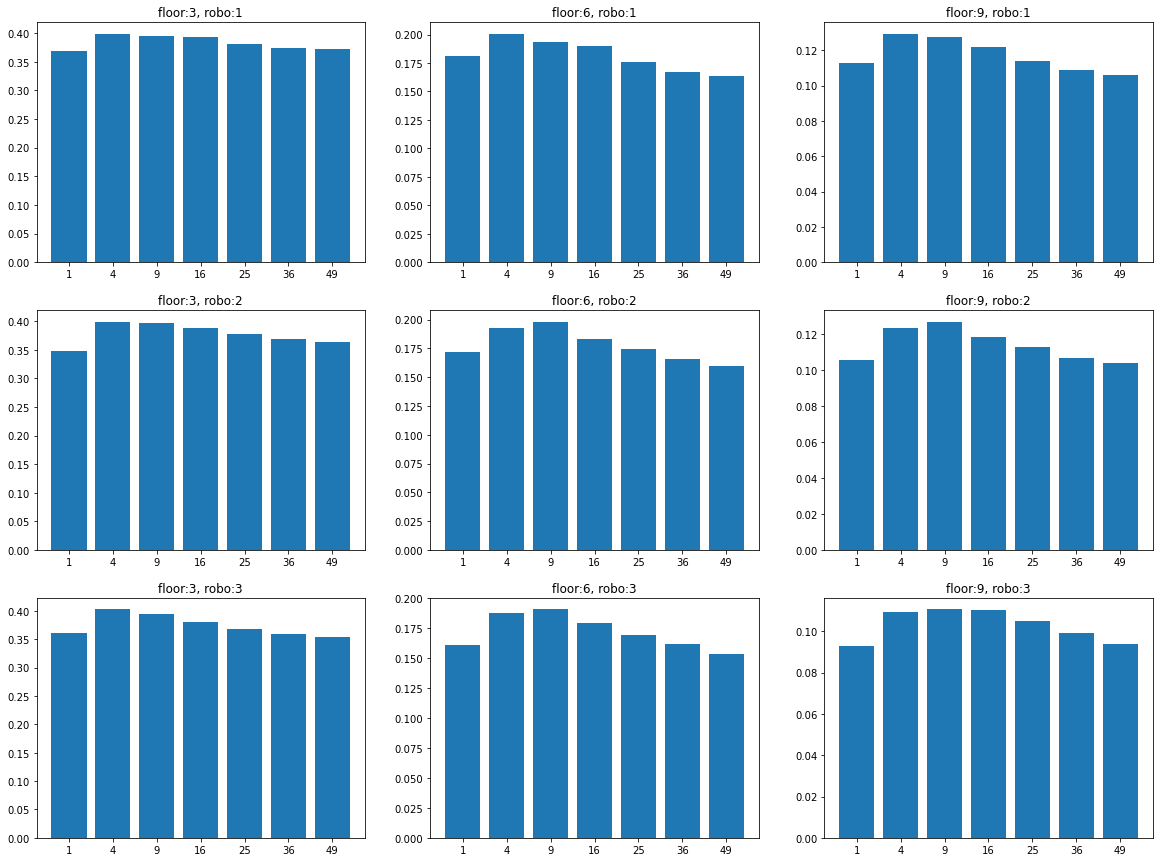

In [460]:
large_df
fig = plt.figure(figsize=(20,15))
for fl in range(3,12,3):
    for rn in range(1,4):
        tmp_df = large_df[(large_df['floor']==fl) & (large_df['roboalloc']==str([rn]*fl))]
        ax = fig.add_subplot(3,3,int(fl/3+(rn-1)*3))
        #タスク完了時間に対する比率
        t = tmp_df.groupby(['pool_size']).mean()['robo_mean_mt'].div(tmp_df.groupby('pool_size').mean()['comp_time'])
        ax.bar([str(tmp) for tmp in t.index],t.values)
        ax.set_title('floor:{}, robo:{}'.format(fl, rn))
        # print(t.index)


## エレベータの比較

### small warehouse

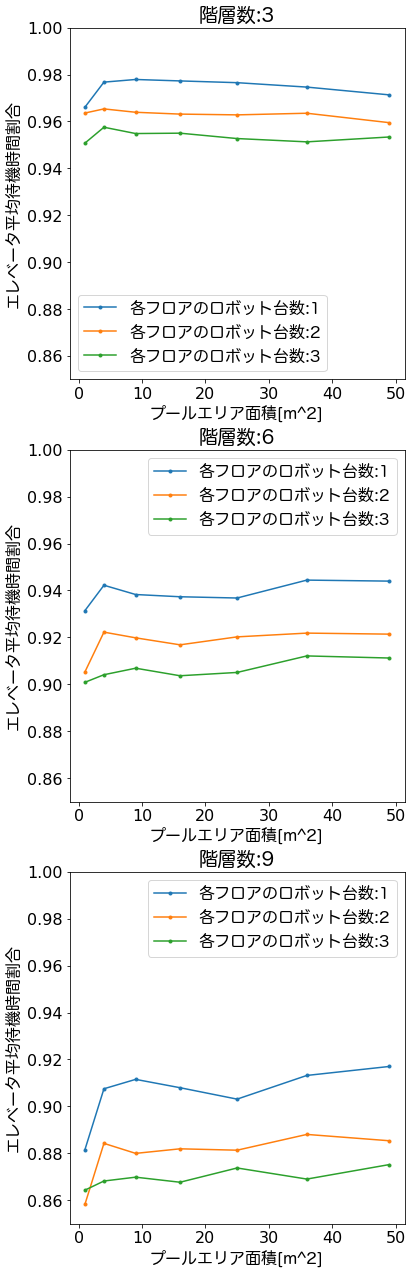

In [549]:

small_df
fig = plt.figure(figsize=(6,22))
for fl in range(3,12,3):
    ax = fig.add_subplot(3,1,int(fl//3))
    for rn in range(1,4):
        tmp_df = small_df[(small_df['floor']==fl) & (small_df['roboalloc']==str([rn]*fl))&(small_df['batch']==(small_df['pool_size']*1.5*0.8//0.5+1)*0.5)]
        # print(tmp_df.info())
        # ax = fig.add_subplot(3,3,int(fl/3+(rn-1)*3))
        
        t = tmp_df.groupby(['pool_size']).mean()['elv_st'].div(tmp_df.groupby('pool_size').mean()['comp_time'])
        #ax.scatter([str(tmp) for tmp in t.index],t.values, label='robot:{}'.format(rn))
        # ax.bar(list(t.index),t.values, label='各フロアのロボット台数:{}'.format(rn),width = 0.8/rn, pos=list(t.index) - 0.8 *( 1- (2*i+1)/rn )/2)
        ax.plot(list(t.index),t.values, label='各フロアのロボット台数:{}'.format(rn),marker=".")
        ax.legend(loc=0,prop={"family":"Hiragino Maru Gothic Pro"})  
        ax.set_title('階層数:{}'.format(fl),fontname="Hiragino Maru Gothic Pro")
        ax.set_xlabel('プールエリア面積[m^2]',fontname="Hiragino Maru Gothic Pro")
        ax.set_ylabel('エレベータ平均待機時間割合',fontname="Hiragino Maru Gothic Pro")
        ax.set_ylim(0.85,1.00)
#ax.set_xlabel('プールエリア面積[m^2]',fontname="Hiragino Maru Gothic Pro")

### large warehouse

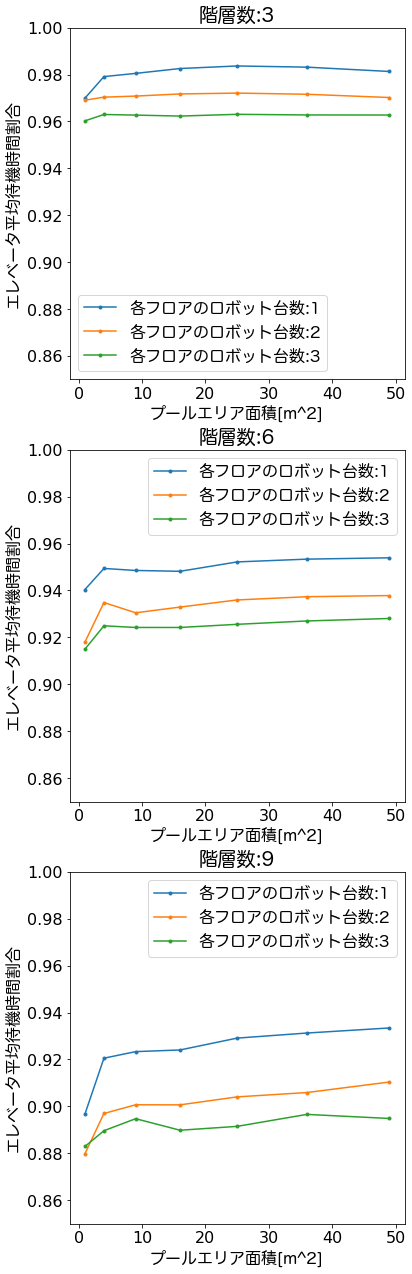

In [550]:

large_df
fig = plt.figure(figsize=(6,22))
for fl in range(3,12,3):
    ax = fig.add_subplot(3,1,int(fl//3))
    for rn in range(1,4):
        tmp_df = large_df[(large_df['floor']==fl) & (large_df['roboalloc']==str([rn]*fl))&(large_df['batch']==(large_df['pool_size']*1.5*0.8//0.5+1)*0.5)]
        # print(tmp_df.info())
        # ax = fig.add_subplot(3,3,int(fl/3+(rn-1)*3))
        
        t = tmp_df.groupby(['pool_size']).mean()['elv_st'].div(tmp_df.groupby('pool_size').mean()['comp_time'])
        #ax.scatter([str(tmp) for tmp in t.index],t.values, label='robot:{}'.format(rn))
        # ax.bar(list(t.index),t.values, label='各フロアのロボット台数:{}'.format(rn),width = 0.8/rn, pos=list(t.index) - 0.8 *( 1- (2*i+1)/rn )/2)
        ax.plot(list(t.index),t.values, label='各フロアのロボット台数:{}'.format(rn),marker=".")
        ax.legend(loc=0,prop={"family":"Hiragino Maru Gothic Pro"})  
        ax.set_title('階層数:{}'.format(fl),fontname="Hiragino Maru Gothic Pro")
        ax.set_xlabel('プールエリア面積[m^2]',fontname="Hiragino Maru Gothic Pro")
        ax.set_ylabel('エレベータ平均待機時間割合',fontname="Hiragino Maru Gothic Pro")
        ax.set_ylim(0.85,1.00)

## フロアごとのロボット稼働時間比較

### small warehouse

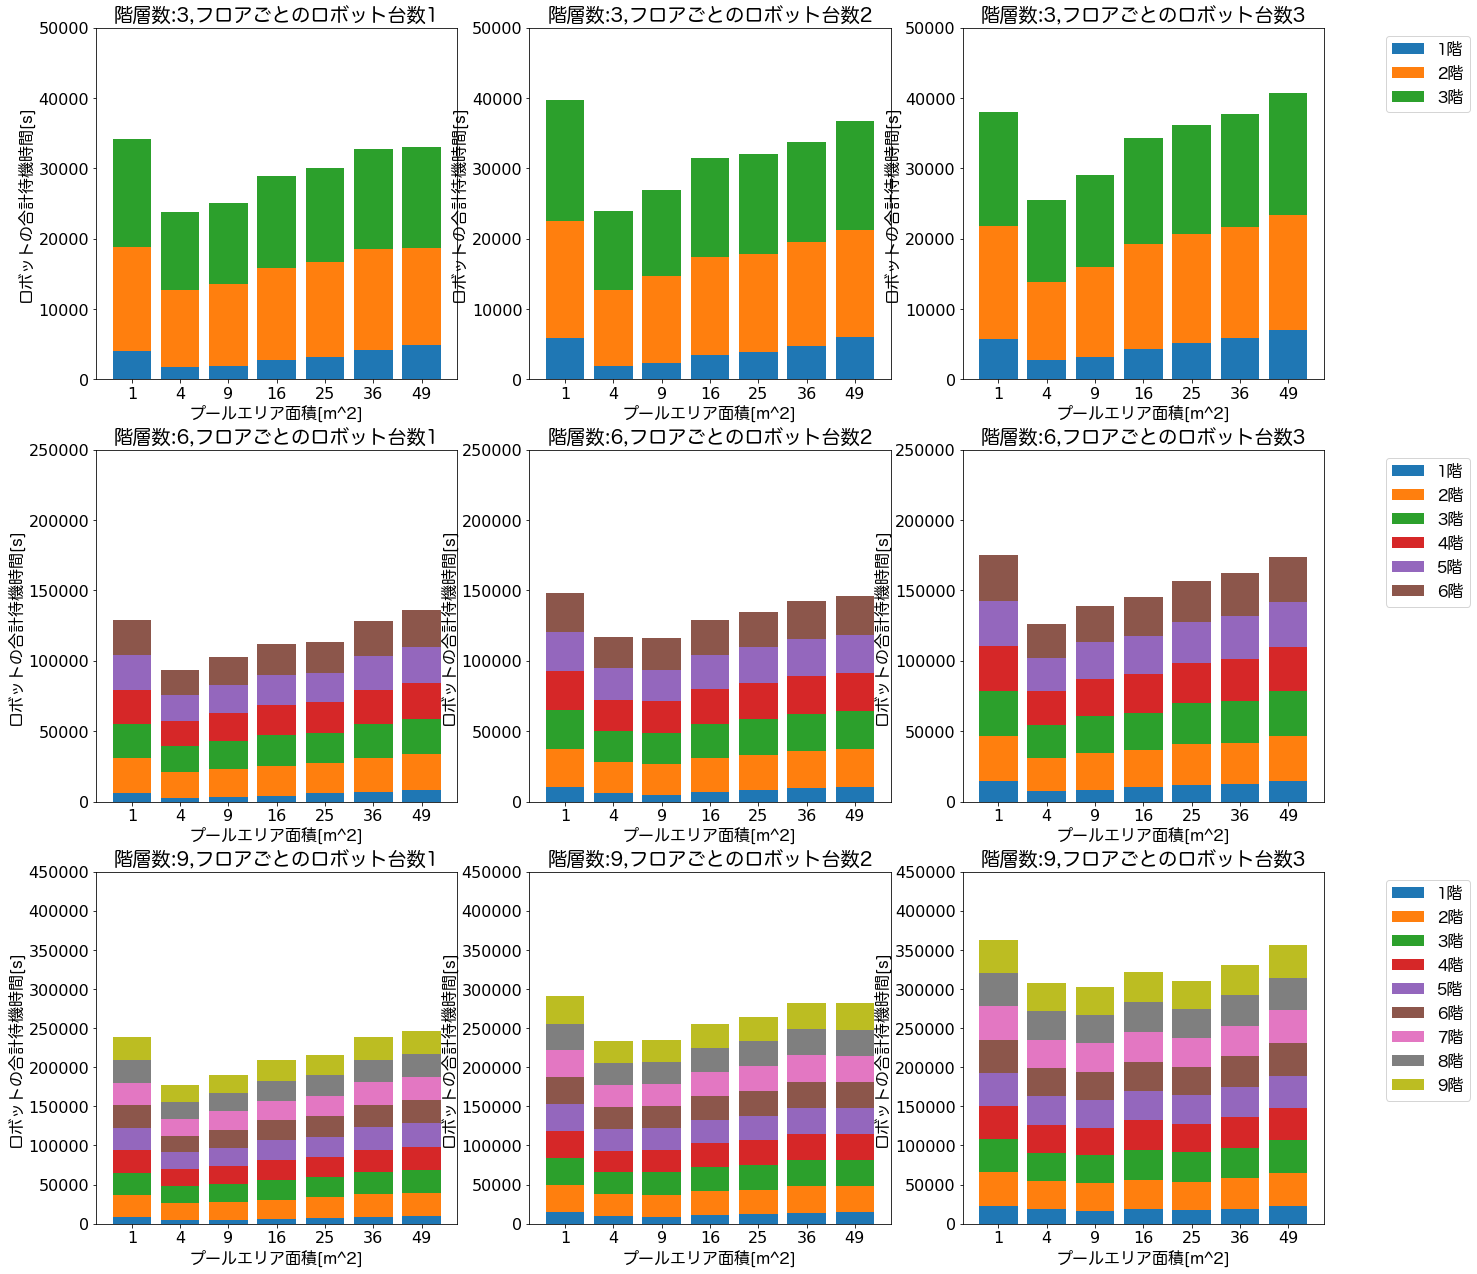

In [553]:
# small_df = df[(df.building=='small_warehouse') & (df.dloc_time==0.0)]
# small_df
# fig = plt.figure(figsize=(20,15))
# for fl in range(3,12,3):
#     #ax = fig.add_subplot(3,3,int(fl//3))
#     for rn in range(1,4):
#         tmp_df = small_df[(small_df['floor']==fl) & (small_df['roboalloc']==str([rn]*fl))&(small_df['batch']==(small_df['pool_size']*0.8//0.5+1)*0.5)]
#         # print(tmp_df.info())
#         ax = fig.add_subplot(3,3,int(fl/3+(rn-1)*3))
        
#         t = tmp_df.groupby(['pool_size']).mean()['comp_time']
#         ax.scatter([str(tmp) for tmp in t.index],t.values, label='robot:{}'.format(rn))
#         ax.legend(loc=0)  
#         ax.set_title('floor:{}'.format(fl))
#         ax.set_xlabel('プールエリア容量[m^3]',fontname="Hiragino Maru Gothic Pro")
#         ax.set_ylabel('全タスク処理時間[s]',fontname="Hiragino Maru Gothic Pro")

small_df
fig = plt.figure(figsize=(22,22))
j=1
for fl in range(3,12,3):
    for rn in range(1,4):
        tmp_df = small_df[(small_df['floor']==fl) & (small_df['roboalloc']==str([rn]*fl))]
        #print(tmp_df)
        ax = fig.add_subplot(3,3,j)
        #タスク完了時間に対する比率
        t = tmp_df.groupby(['pool_size']).mean()#.div(tmp_df.groupby('pool_size').mean()['comp_time'])
        tr = t.loc[:,'robo_f01_mt':'robo_f0{}_td'.format(fl)]#.div(tmp_df.groupby('pool_size').mean()['comp_time'], axis=0)
        tr  = tr.iloc[:,list(range(2,fl*4,4))]
        tr_t = tr.T
        for i in range(len(tr_t)):
            ax.bar([str(tmp) for tmp in tr_t.columns], tr_t.iloc[i]*rn,bottom=tr_t.iloc[:i].sum()*rn)
            legend=['{}階'.format(n+1) for n in range(fl)]
            #ax.legend(legend,loc=0,prop={"family":"Hiragino Maru Gothic Pro"}) 
            #ax.legend(tr_t.index,loc=0) 
            ax.set_title('階層数:{},フロアごとのロボット台数{}'.format(fl,rn),fontname="Hiragino Maru Gothic Pro")
            ax.set_xlabel('プールエリア面積[m^2]',fontname="Hiragino Maru Gothic Pro")
            ax.set_ylabel('ロボットの合計待機時間[s]',fontname="Hiragino Maru Gothic Pro")
            if fl==3:
                ax.set_ylim(0,50000)
            elif fl==6:
                ax.set_ylim(0,250000)
            else:
                ax.set_ylim(0,450000)
        j+=1
    ax.legend(legend,bbox_to_anchor=(1.15, 1),prop={"family":"Hiragino Maru Gothic Pro"}) 
            

### large warehouse

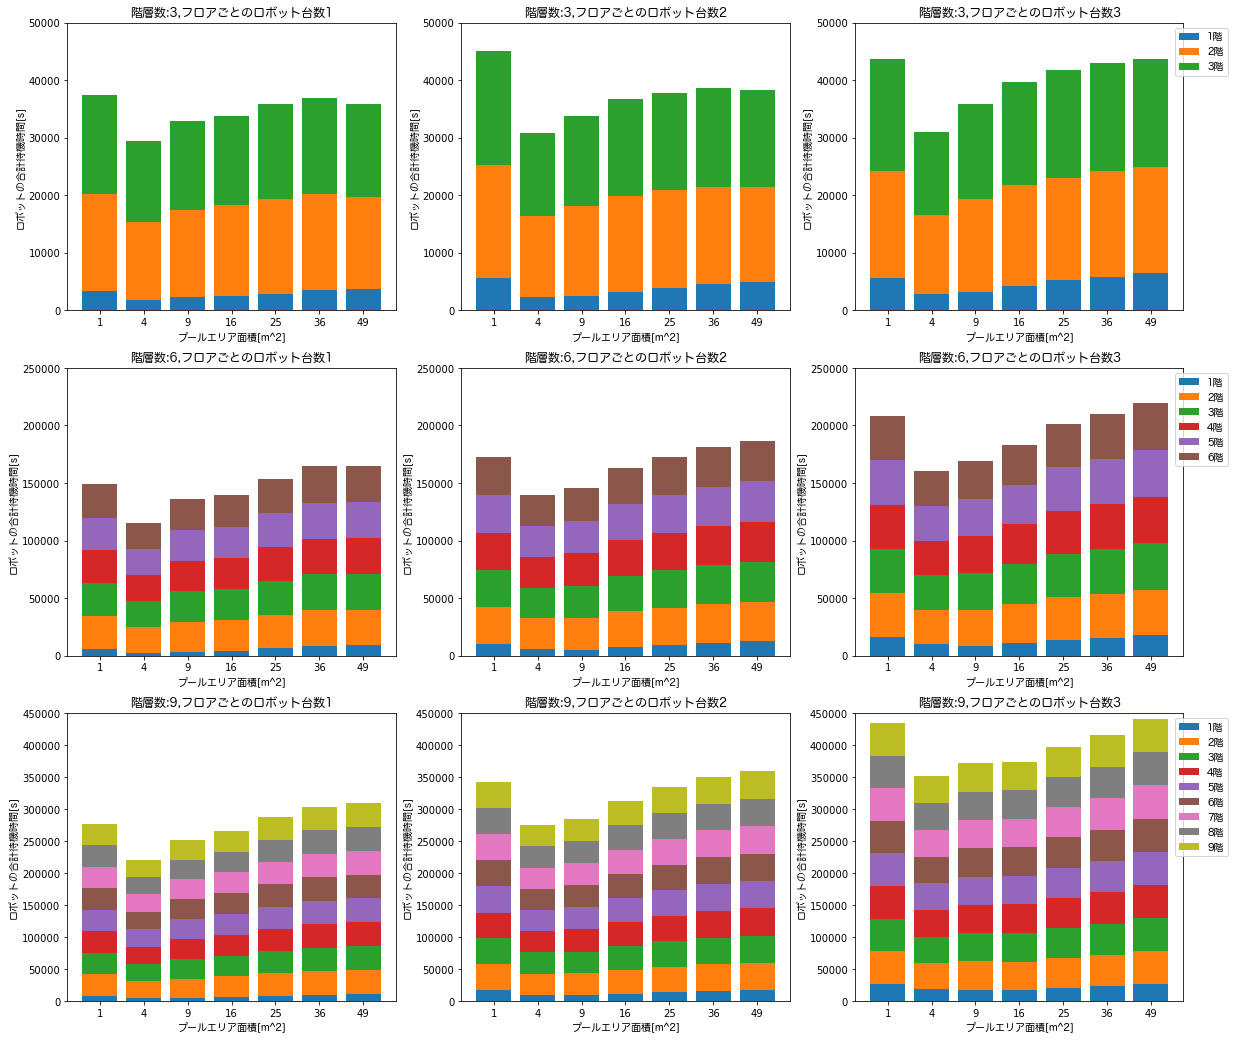

In [540]:
large_df
fig = plt.figure(figsize=(20,18))
j=1
for fl in range(3,12,3):
    for rn in range(1,4):
        tmp_df = large_df[(large_df['floor']==fl) & (large_df['roboalloc']==str([rn]*fl))]
        #print(tmp_df)
        ax = fig.add_subplot(3,3,j)
        #タスク完了時間に対する比率
        t = tmp_df.groupby(['pool_size']).mean()#.div(tmp_df.groupby('pool_size').mean()['comp_time'])
        tr = t.loc[:,'robo_f01_mt':'robo_f0{}_td'.format(fl)]#.div(tmp_df.groupby('pool_size').mean()['comp_time'], axis=0)
        tr  = tr.iloc[:,list(range(2,fl*4,4))]
        tr_t = tr.T
        for i in range(len(tr_t)):
            ax.bar([str(tmp) for tmp in tr_t.columns], tr_t.iloc[i]*rn,bottom=tr_t.iloc[:i].sum()*rn)
            legend=['{}階'.format(n+1) for n in range(fl)]
            #ax.legend(legend,loc=0,prop={"family":"Hiragino Maru Gothic Pro"}) 
            #ax.legend(tr_t.index,loc=0) 
            ax.set_title('階層数:{},フロアごとのロボット台数{}'.format(fl,rn),fontname="Hiragino Maru Gothic Pro")
            ax.set_xlabel('プールエリア面積[m^2]',fontname="Hiragino Maru Gothic Pro")
            ax.set_ylabel('ロボットの合計待機時間[s]',fontname="Hiragino Maru Gothic Pro")
            if fl==3:
                ax.set_ylim(0,50000)
            elif fl==6:
                ax.set_ylim(0,250000)
            else:
                ax.set_ylim(0,450000)
        j+=1
    ax.legend(legend,bbox_to_anchor=(1.15, 1),prop={"family":"Hiragino Maru Gothic Pro"}) 

## バッチサイズごとの比較

### small warehouse

In [274]:
small_df
fig = plt.figure(figsize=(20,15))
for fl in range(3,12,3):
    for rn in range(1,4):
        for batch in small_df['batch'].unique():
            tmp_df = small_df[(small_df['floor']==fl) & (small_df['roboalloc']==str([rn]*fl))& (small_df['batch']==batch)]
            # print(batch)
            # print(tmp_df)
            # ax = fig.add_subplot(3,3,int(fl/3+(rn-1)*3))
            # #タスク完了時間に対する比率
            # t = tmp_df.groupby(['pool_size']).mean()#.div(tmp_df.groupby('pool_size').mean()['comp_time'])
            # #print(t)
            # t['comp_time']
            # # tr = t.loc[:,'robo_f01_mt':'robo_f0{}_td'.format(fl)].div(tmp_df.groupby('pool_size').mean()['comp_time'], axis=0)
            # # tr.iloc[:,list(range(0,fl*4,4))].plot.bar()
            # print(tmp_df)
s = small_df[(small_df['floor']==3) & (small_df['roboalloc']==str([2]*3))]
s.groupby(['pool_size','batch']).mean()

floor  robonum     comp_time  dloc_time  robo_f01_mt  \
pool_size batch                                                         
1.5       1.0      3.0      6.0  14092.333333        0.0  5622.050000   
          1.5      3.0      6.0  14240.710526        0.0  5780.081579   
6.0       1.0      3.0      6.0  11123.180000        0.0  4853.720000   
          3.0      3.0      6.0  11342.366667        0.0  5119.466667   
          5.0      3.0      6.0  11146.638636        0.0  5003.131818   
...                ...      ...           ...        ...          ...   
150.0     13.0     3.0      6.0  12864.775000        0.0  5079.725000   
          15.0     3.0      6.0  13105.000000        0.0  5337.350000   
          17.0     3.0      6.0  12676.850000        0.0  5113.250000   
          19.0     3.0      6.0  12851.625000        0.0  4839.162500   
          120.5    3.0      6.0  13483.346875        0.0  4596.906250   

                 robo_f01_at  robo_f01_st  robo_f01_td  robo_f02_mt  \
pool_size batch                                                       
1.5       1.0    5226.725000  3017.633333  3665.540000  3032.866667   
          1.5    5197.001316  3033.750000  3769.684474  3066.459211   
6.0       1.0    5061.790000  1004.920000  3176.362000  3159.770000   
          3.0    5085.983333   928.466667  3351.420000  2904.650000   
          5.0    4992.215909   946.952273  3274.806136  3070.125000   
...                      ...          ...          ...          ...   
150.0     13.0   5204.950000  2321.425000  3335.767500  3226.437500   
          15.0   5290.150000  2212.000000  3504.970000  3441.200000   
          17.0   5186.725000  2117.875000  3357.255000  3230.200000   
          19.0   5226.150000  2533.625000  3176.585000  3104.662500   
          120.5  5178.392187  3460.465625  3020.803438  2855.898438   

                 robo_f02_at  ...  robo_f09_mt  robo_f09_at  robo_f09_st  \
pool_size batch               ...                                          
1.5       1.0    2678.591667  ...          NaN          NaN          NaN   
          1.5    2667.659211  ...          NaN          NaN          NaN   
6.0       1.0    2648.890000  ...          NaN          NaN          NaN   
          3.0    2460.966667  ...          NaN          NaN          NaN   
          5.0    2576.768182  ...          NaN          NaN          NaN   
...                      ...  ...          ...          ...          ...   
150.0     13.0   2802.312500  ...          NaN          NaN          NaN   
          15.0   2913.400000  ...          NaN          NaN          NaN   
          17.0   2768.075000  ...          NaN          NaN          NaN   
          19.0   2732.425000  ...          NaN          NaN          NaN   
          120.5  2613.948438  ...          NaN          NaN          NaN   

                 robo_f09_td  robo_mean_mt  robo_mean_at  robo_mean_st  \
pool_size batch                                                          
1.5       1.0            NaN   3809.169444   3513.130556   3513.130556   
          1.5            NaN   3896.737281   3489.799123   3489.799123   
6.0       1.0            NaN   3646.300000   3413.116667   3413.116667   
          3.0            NaN   3673.233333   3414.266667   3414.266667   
          5.0            NaN   3646.549621   3361.658712   3361.658712   
...                      ...           ...           ...           ...   
150.0     13.0           NaN   3787.708333   3526.991667   3526.991667   
          15.0           NaN   3844.866667   3582.333333   3582.333333   
          17.0           NaN   3799.075000   3518.608333   3518.608333   
          19.0           NaN   3558.304167   3517.170833   3517.170833   
          120.5          NaN   3418.605729   3478.929167   3478.929167   

                 robo_mean_td      elv_mt       elv_td  
pool_size batch                                         
1.5       1.0     2481.045556  548.233333  1644.700000  
          1.5     25

<Figure size 1440x1080 with 0 Axes>

In [275]:
i
small_df['batch'].unique()

array([  1.5,   1. ,   5. ,   3. ,  11. ,   7. ,   9. ,  19.5,  15. ,
        17. ,  19. ,  13. ,  30.5,  43.5,  59. ,  77. ,  97.5, 120.5])

ValueError: num must be 1 <= num <= 63, not 64

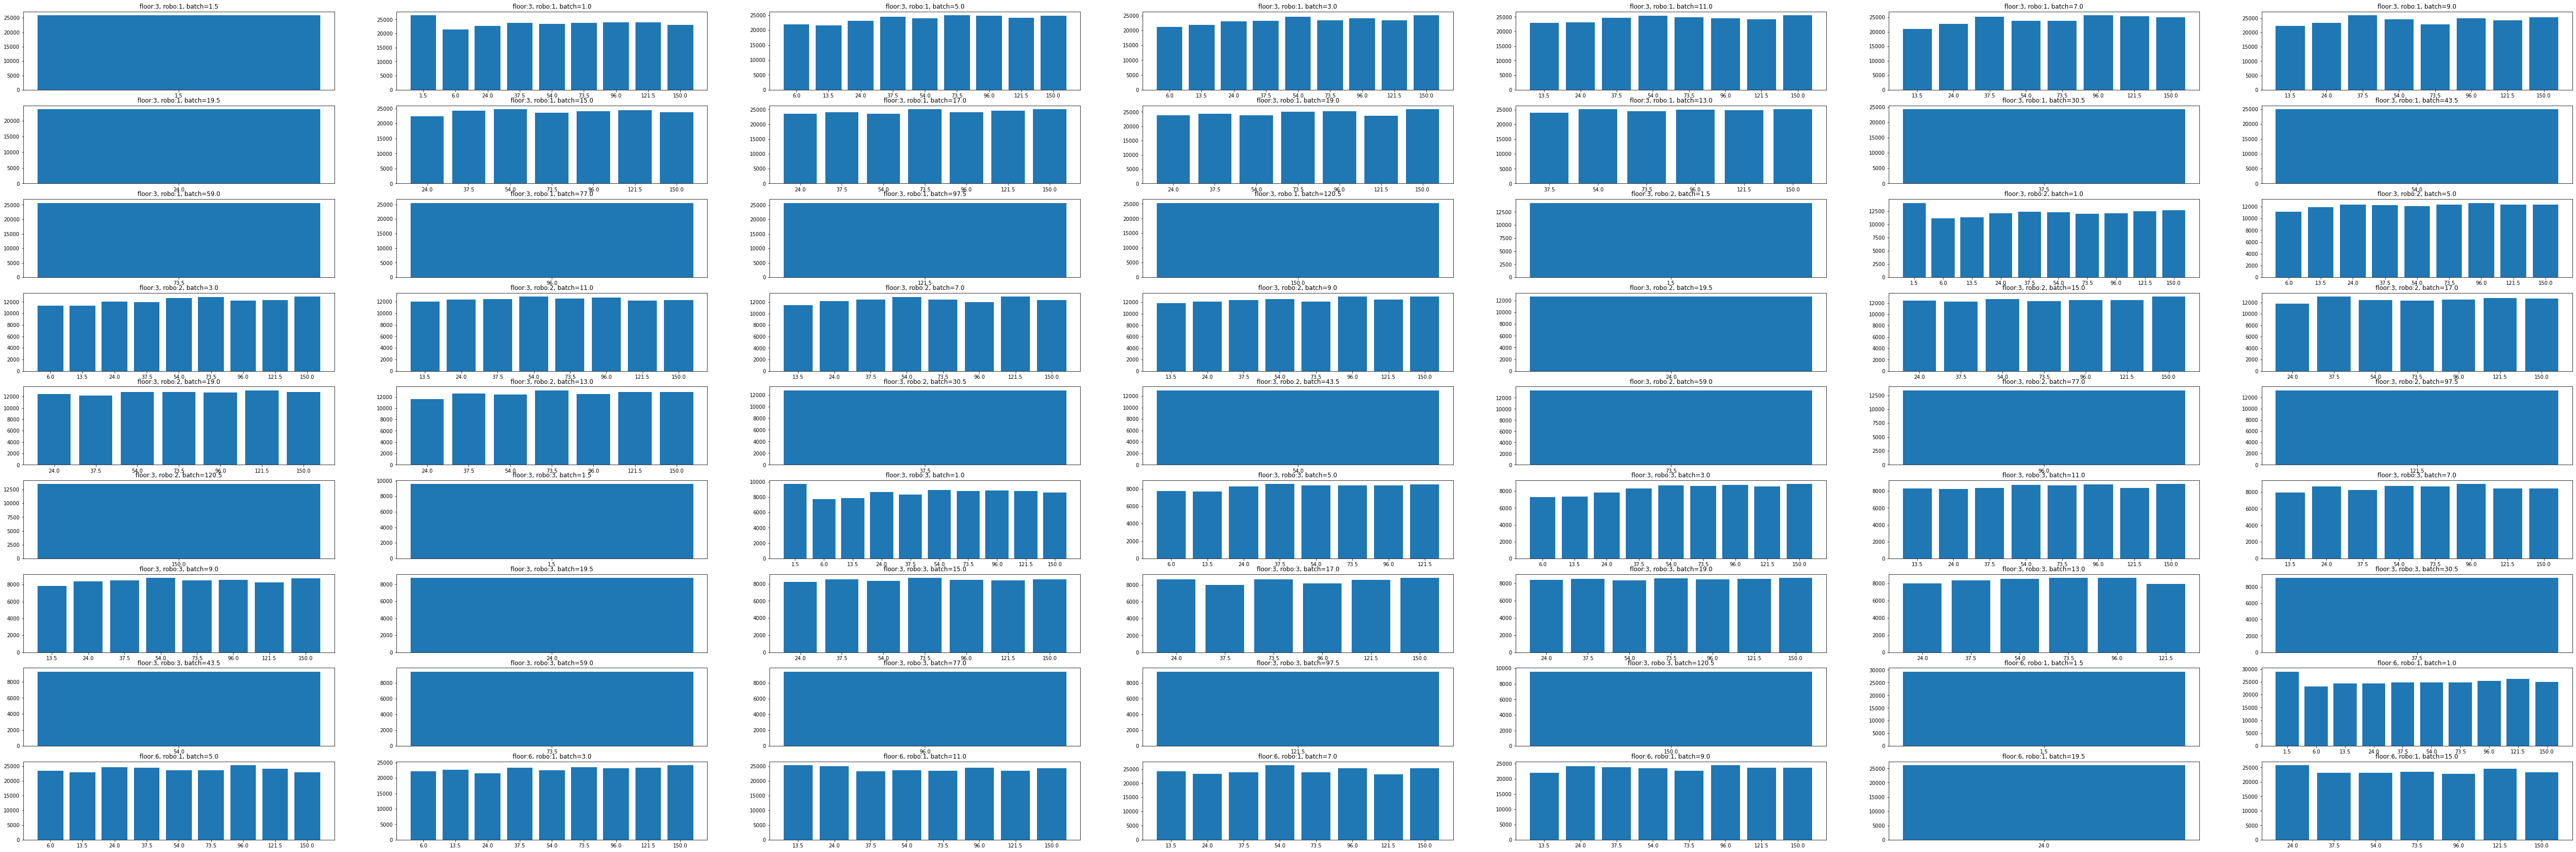

In [276]:
small_df
fig = plt.figure(figsize=(90,30))
i=1
for fl in range(3,12,3):
    for rn in range(1,4):
        for batch in small_df['batch'].unique():
            tmp_df = small_df[(small_df['floor']==fl) & (small_df['roboalloc']==str([rn]*fl))& (small_df['batch']==batch)]
            ax = fig.add_subplot(9,7,i)
            #タスク完了時間に対する比率
            t = tmp_df.groupby(['pool_size']).mean()['comp_time']
            ax.bar([str(tmp) for tmp in t.index],t.values)
            ax.set_title('floor:{}, robo:{}, batch={}'.format(fl, rn, batch))
            i+=1

### タスク完了時間のプロット

../record/large_warehouse/floor06/robonum006/P/pool0049/2022-05-19-16-17.json


Text(0.5, 1.0, '階層数:6, フロアごとのロボット台数:1, プールエリア面積:49[m^2]')

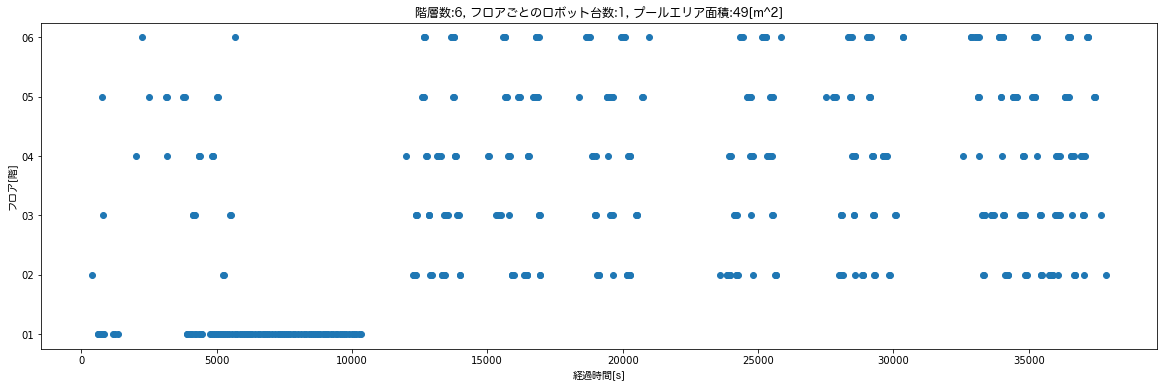

In [517]:

record = {"pickfloor":[], "dfloor":[], "deli_time":[]}
n =0
#bldg = ['small_warehouse', 'large_warehouse']
bldg = 'large_warehouse'
fl = 6
p = 7
l_path = '../record/{}/floor0{}/robonum0{}/P/pool0{}/*.json'.format(bldg, fl, str(fl).zfill(2), str(p**2).zfill(3))
# print(glob.glob(l_path))
l_files = natsorted(glob.glob(l_path))
# print(n)
# print(file.split('/')[-1] lambda x: file in l_files)
l_file = l_files[-1]
print(l_file)
# for l_file in l_files:
#     # print(l_file.split('/')[2:])
content = []
with open(l_file) as f:
    content = json.load(f)
    for palet, val in content["task"].items():
        record["pickfloor"].append(val["pickup"][10:12])
        record["dfloor"].append(val["destination"][10:12])
        if "completed_time" in val.keys():
            record["deli_time"].append(val["completed_time"])
        else:
            record["deli_time"].append(None)
        rn=sum(content['input']['robot_allocation'])
rdf = pd.DataFrame(record)
rdf = rdf.sort_values("dfloor")

fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(1,1,1)
#タスク完了時間に対する比率
ax.scatter([dt for dt in rdf.deli_time],rdf["dfloor"])
ax.set_title('階層数:{},フロアごとのロボット台数{}'.format(fl,rn),fontname="Hiragino Maru Gothic Pro")
ax.set_xlabel('経過時間[s]',fontname="Hiragino Maru Gothic Pro")
ax.set_ylabel('フロア[階]',fontname="Hiragino Maru Gothic Pro")
ax.set_title('階層数:{}, フロアごとのロボット台数:{}, プールエリア面積:{}[m^2]'.format(fl, int(rn/fl), p**2), fontname="Hiragino Maru Gothic Pro")

## 待ち時間割合

/Users/tacky/miniforge3/envs/twinu_alpha/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tacky/miniforge3/envs/twinu_alpha/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


AxisError: axis 1 is out of bounds for array of dimension 1

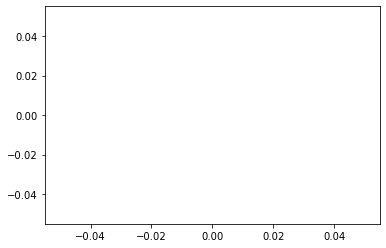

In [339]:



fig, ax = plt.subplots(facecolor="w")
plt.bar(x, np.mean(n_waitRate, axis=1), width=-0.3, align="edge", label='ベースライン')
plt.bar(x, np.mean(e_waitRate,axis=1), width=0.3, align="edge", label='提案手法')
# ax.bar(x, n_extraStopTime, label='extraStopTime')
# ax.bar(x, n_waitTime, label='waitTime')
# ax.bar(x, n_waitTime, label='waitTime')
plt.xlabel('ロボット(台)', fontname="Hiragino Maru Gothic Pro")
plt.ylabel('待ち時間割合', fontname="Hiragino Maru Gothic Pro")
plt.title( '待ち時間割合(3階層)', fontname="Hiragino Maru Gothic Pro")
plt.legend(prop={"family":"Hiragino Maru Gothic Pro"})
plt.show()

sns.boxplot( 
    data=pd.DataFrame(n_waitRate, index=x).T,
    #patch_artist=True,  
    #widths=0.5,  # boxの幅の設定
    boxprops=dict(facecolor='#1E90FF80',  # boxの塗りつぶし色の設定
                         color='black', linewidth=1)
)
#sns.boxplot( data=pd.DataFrame(e_waitRate, index=x).T)
ratio = np.mean(e_waitRate,axis=1)/np.mean(n_waitRate, axis=1)
print(ratio*100)

# 待ち時間

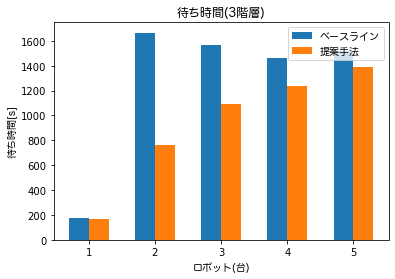

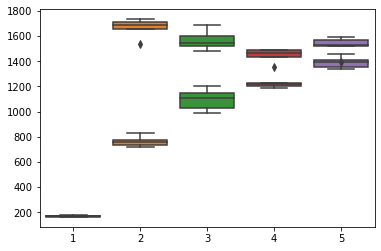

In [89]:
fig, ax = plt.subplots(facecolor="w")
plt.bar(x, np.mean(n_waitTime, axis=1), width=-0.3, align="edge", label='ベースライン')
plt.bar(x, np.mean(e_waitTime,axis=1), width=0.3, align="edge", label='提案手法')
# ax.bar(x, n_extraStopTime, label='extraStopTime')
# ax.bar(x, n_waitTime, label='waitTime')
# ax.bar(x, n_waitTime, label='waitTime')
plt.xlabel('ロボット(台)', fontname="Hiragino Maru Gothic Pro")
plt.ylabel('待ち時間[s]', fontname="Hiragino Maru Gothic Pro")
plt.title( '待ち時間(3階層)', fontname="Hiragino Maru Gothic Pro")
plt.legend(prop={"family":"Hiragino Maru Gothic Pro"})
plt.show()

sns.boxplot( data=pd.DataFrame(n_waitTime, index=x).T)
sns.boxplot( data=pd.DataFrame(e_waitTime, index=x).T)
ratio = np.mean(e_waitRate,axis=1)/np.mean(n_waitRate, axis=1)

# 余分なカゴ停止時間割合

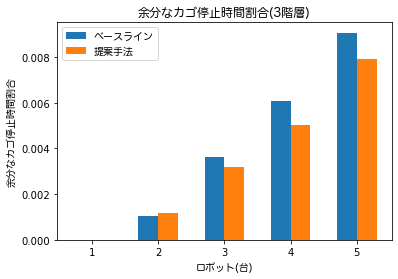

In [90]:
fig, ax = plt.subplots(facecolor="w")
plt.bar(x, np.mean(n_extraStopRate,axis=1), width=-0.3, align="edge", label='ベースライン')
plt.bar(x, np.mean(e_extraStopRate,axis=1), width=0.3, align="edge", label='提案手法')
# ax.bar(x, n_extraStopTime, label='extraStopTime')
# ax.bar(x, n_waitTime, label='waitTime')
# ax.bar(x, n_waitTime, label='waitTime')
plt.xlabel('ロボット(台)', fontname="Hiragino Maru Gothic Pro")
plt.ylabel('余分なカゴ停止時間割合', fontname="Hiragino Maru Gothic Pro")
plt.title('余分なカゴ停止時間割合(3階層)', fontname="Hiragino Maru Gothic Pro")
plt.legend(prop={"family":"Hiragino Maru Gothic Pro"})
plt.show()

# 余分なカゴ停止時間

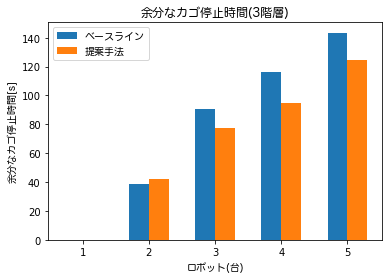

In [91]:
fig, ax = plt.subplots(facecolor="w")
plt.bar(x, np.mean(n_extraStopTime, axis=1), width=-0.3, align="edge", label='ベースライン')
plt.bar(x, np.mean(e_extraStopTime,axis=1), width=0.3, align="edge", label='提案手法')
# ax.bar(x, n_extraStopTime, label='extraStopTime')
# ax.bar(x, n_waitTime, label='waitTime')
# ax.bar(x, n_waitTime, label='waitTime')
plt.xlabel('ロボット(台)', fontname="Hiragino Maru Gothic Pro")
plt.ylabel('余分なカゴ停止時間[s]', fontname="Hiragino Maru Gothic Pro")
plt.title('余分なカゴ停止時間(3階層)', fontname="Hiragino Maru Gothic Pro")
plt.legend(prop={"family":"Hiragino Maru Gothic Pro"})
plt.show()

# タスク処理時間

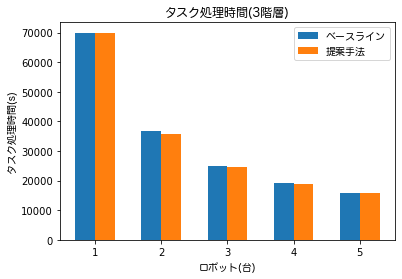

[99.99202498 96.88924847 97.54764428 98.59845589 99.61450817]


In [92]:
fig, ax = plt.subplots(facecolor="w")
plt.bar(x, np.mean(n_processingTime,axis=1), width=-0.3, align="edge", label='ベースライン')
plt.bar(x, np.mean(e_processingTime,axis=1), width=0.3, align="edge", label='提案手法')
# ax.bar(x, n_extraStopTime, label='extraStopTime')
# ax.bar(x, n_waitTime, label='waitTime')
# ax.bar(x, n_waitTime, label='waitTime')
plt.xlabel('ロボット(台)', fontname="Hiragino Maru Gothic Pro")
plt.ylabel('タスク処理時間(s)', fontname="Hiragino Maru Gothic Pro")
plt.title('タスク処理時間(3階層)', fontname="Hiragino Maru Gothic Pro")
plt.legend(prop={"family":"Hiragino Maru Gothic Pro"})
plt.show()

ratio = np.mean(e_processingTime,axis=1)/np.mean(n_processingTime, axis=1)
print(ratio*100)